In [1]:
import os
os.chdir("..")
import shutil
import warnings
warnings.simplefilter('ignore')

from fp.traindata_samplers import CompleteData
from fp.missingvalue_handlers import CompleteCaseAnalysis
from fp.dataset_experiments import GermanCreditDatasetSexExperiment
from fp.dataset_experiments import RicciRaceExperiment
from fp.scalers import NamedStandardScaler, NamedMinMaxScaler
from fp.learners import NonTunedLogisticRegression, LogisticRegression, DecisionTree, NonTunedLogisticRegression, NonTunedDecisionTree          
from fp.post_processors import NoPostProcessing,RejectOptionPostProcessing, EqualOddsPostProcessing, CalibratedEqualOddsPostProcessing
from fp.pre_processors import NoPreProcessing, DIRemover, Reweighing

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
seeds = [0xbeef, 0xcafe, 0xdead, 0xdeadcafe, 0xdeadbeef, 0xbeefcafe, 0xcafebeef, 50, 583, 5278, 100000, 0xefac,0xfeeb, 0xdaed, 0xefacdaed, 0xfeebdead]
samplers = [CompleteData()]
missings = [CompleteCaseAnalysis()]
scalers = [NamedMinMaxScaler(), NamedStandardScaler()]
learners = [NonTunedLogisticRegression(), LogisticRegression(), NonTunedDecisionTree(), DecisionTree()]
post_processors = [NoPostProcessing(),RejectOptionPostProcessing(), CalibratedEqualOddsPostProcessing()]
pre_processors = [NoPreProcessing(), DIRemover(1.0), DIRemover(0.5), Reweighing()]

In [3]:
path = os.path.join(os.getcwd(), "logs")

def extract_info(present_acc,present_di,present_fnr,present_fpr):
    '''
    Function to extract the metrics (accuracy, DI, false_positive_rate, false_negative_rate)value from the log files 
    '''
    try:
        for folderName, subfolders, filenames in os.walk(path):      
            for subfolder in subfolders:
                filelist = os.listdir(path+'/'+subfolder)
                for f in filelist:
                    file_path = path+'/'+subfolder+'/'+f
                    with open(file_path,'r+') as f:
                        for line in f:
                            
                            if line.startswith("test,,disparate_impact"):
                                di = line.split(',')
                                di_value = di[-1].rstrip("\n")
                                present_di.append(float(di_value))
                            
                            elif line.startswith("test") and 'accuracy' in line and 'None' in line:
                                acc = line.split(',')
                                acc_val = acc[-1].rstrip("\n")
                                present_acc.append(float(acc_val))
                            
                            elif line.startswith("test") and 'generalized_false_positive_rate' in line and 'None' in line:
                                fnr = line.split(',')
                                fnr_val = fnr[-1].rstrip("\n")
                                present_fnr.append(float(fnr_val))
                            
                            elif line.startswith("test") and 'generalized_true_positive_rate' in line and 'None' in line:
                                fpr = line.split(',')
                                fpr_val = fpr[-1].rstrip("\n")
                                present_fpr.append(float(fpr_val))
                shutil.rmtree(path+'/'+subfolder)            
    except:
        pass
    return present_acc,present_di,present_fnr,present_fpr

In [4]:
def exp_run_pre_pro_param(seed,learn,pre,post):
    '''
    Experiment function to run the experiments
    '''
    exp = GermanCreditDatasetSexExperiment(
    fixed_random_seed=seed,
    train_data_sampler=CompleteData(),
    missing_value_handler=CompleteCaseAnalysis(),
    numeric_attribute_scaler=NamedStandardScaler(),
    learners=[learn],
    pre_processors=[pre],
    post_processors=[post]
    )
    
    exp.run()

In [5]:
#Mergining processors to one format for input
processors = [[NoPreProcessing(),NoPostProcessing()], [DIRemover(1.0),NoPostProcessing()], [DIRemover(0.5),NoPostProcessing()], [Reweighing(),NoPostProcessing()],
              [NoPreProcessing(), RejectOptionPostProcessing()],[NoPreProcessing(),CalibratedEqualOddsPostProcessing()]]

In [6]:
%%capture
accuracy, disp_imp, fpr, fnr  = [], [], [], []

def run_exp(accuracy,disp_imp,fnr,fpr,seeds,learners,processors):
    '''
    This is the main driver function that calls the exp_run to run on combinations of various learners, pre and post processing techniques
    '''
    for processor in processors:
        for learn in learners:
            present_acc, present_di, present_fnr, present_fpr = [], [], [], []
            for seed in seeds:
                exp_run_pre_pro_param(seed, learn, pre = processor[0], post = processor[1])
                present_acc, present_di, present_fnr, present_fpr = extract_info(present_acc,present_di, present_fnr, present_fpr)
            accuracy.append(present_acc)
            disp_imp.append(present_di)
            fnr.append(present_fnr)
            fpr.append(present_fpr)
    return accuracy, disp_imp, fnr, fpr
            
accuracy, disp_imp, fnr, fpr  = run_exp(accuracy,disp_imp,fnr,fpr,seeds,learners,processors);

In [7]:
def plotter(p_x, p_y, x_ticks, xlabel,main_title):
    '''
    Function to plot various comparison plots.
    '''
    title_list = ['NoPreProcessing','DIRemover(1.0)','DIRemover(0.5)','Reweighing','Reject Option','Caliberated Equal Odds']
    label_list = [['NonTunedLogistic','TunedLogistic'],['NonTunedDecisionTree','TunedDecisionTree']] 
    fig, axs = plt.subplots(6,2,figsize=((10,20)))
    axs = axs.flatten()
    for i in range(0,len(accuracy),2):
        axs[i//2].scatter(p_x[i], accuracy[i],c='b',marker='o')
        axs[i//2].scatter(p_x[i+1], accuracy[i+1],c='r',marker='o')
        axs[i//2].set_xticks(x_ticks)
        axs[i//2].set_yticks(np.arange(0.5,1,0.1))
        axs[i//2].set_title(title_list[i//4])
        axs[i//2].grid(True)
        axs[i//2].set_xlabel(xlabel)
        axs[i//2].set_ylabel('Accuracy')
        axs[i//2].legend(label_list[int(i%4/2)])
    fig.suptitle(main_title)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.43)
    plt.show()

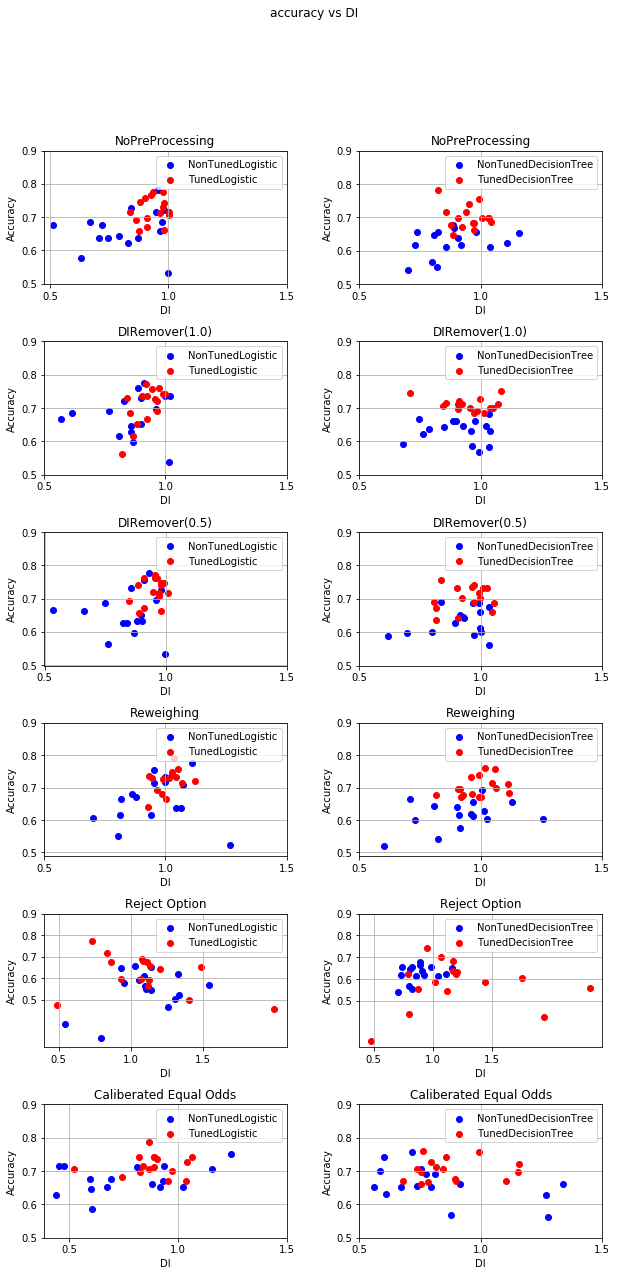

In [8]:
%matplotlib inline
plotter(disp_imp, accuracy, [0.5,1,1.5],  'DI', 'accuracy vs DI')

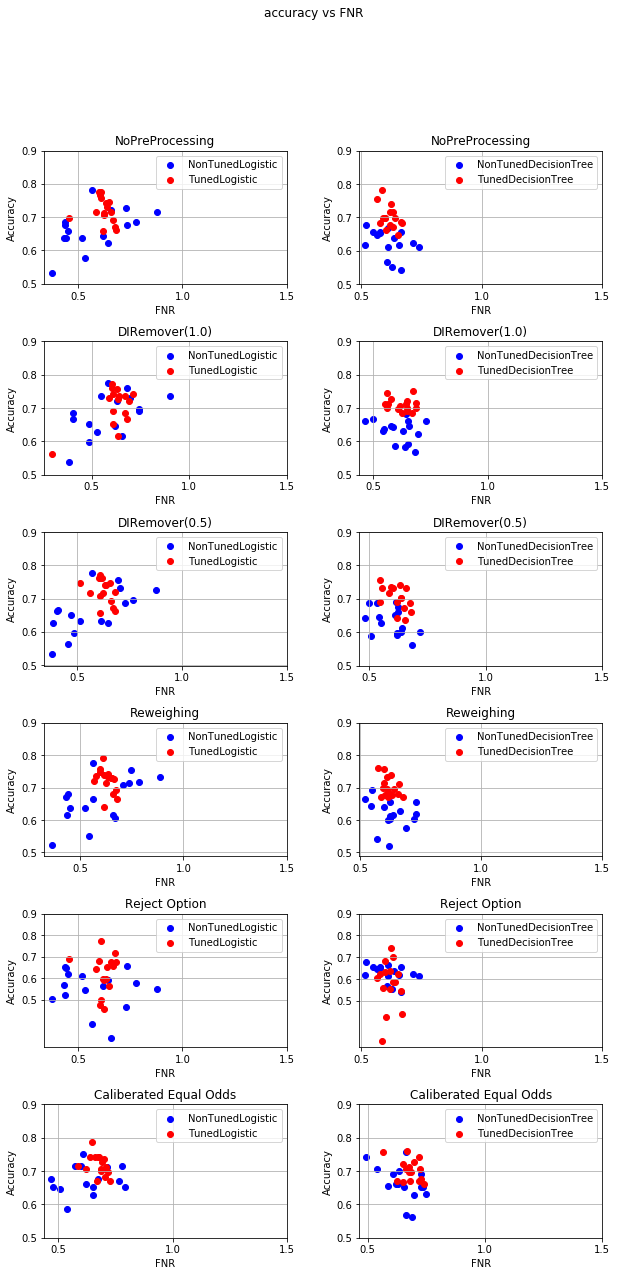

In [9]:
plotter(fnr, accuracy, [0.5,1,1.5], 'FNR','accuracy vs FNR')

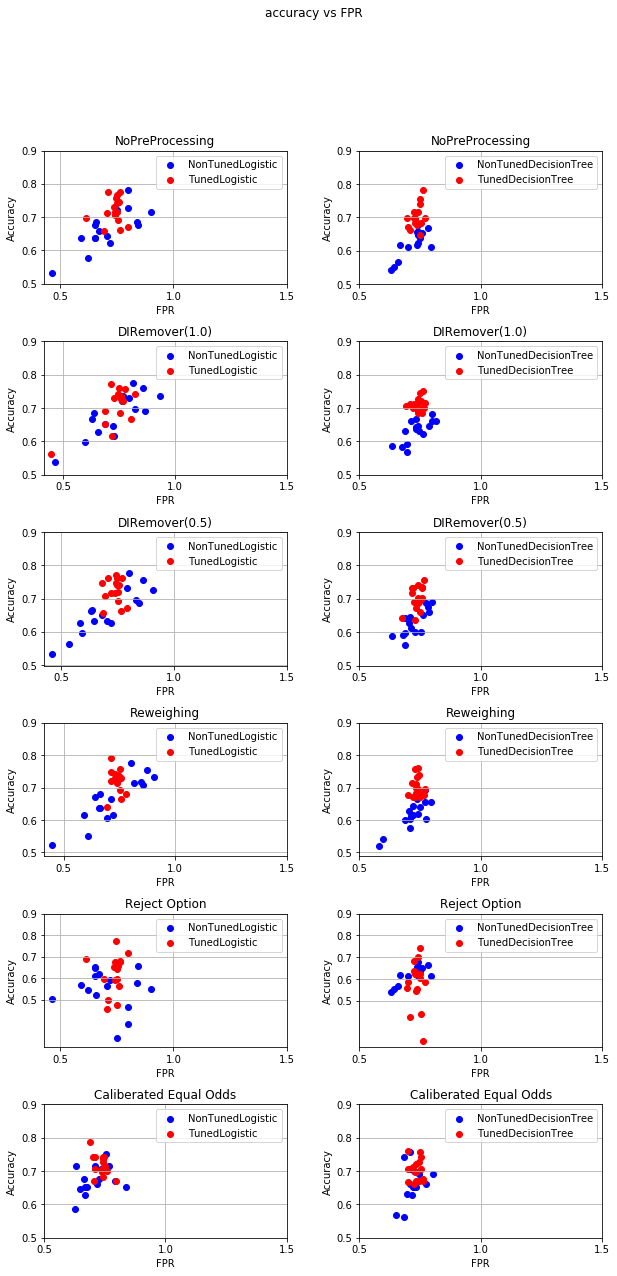

In [10]:
plotter(fpr, accuracy, [0.5,1,1.5], 'FPR','accuracy vs FPR')